### Import packages & load data

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import filtfilt, butter
from scipy.ndimage import binary_closing, binary_opening

from utils import extract_features, decompose_segment, segment_column, synchronize_trials, top_bot_25, z_normalize_column

eeg_data_1 = pd.read_csv('data/muselsl-sample-10min-3.csv')
gradcpt_data_1 = pd.read_csv('data/gradcpt-sample-10min-3.csv')
eeg_data_2 = pd.read_csv('data/muselsl-sample-10min-4.csv')
gradcpt_data_2 = pd.read_csv('data/gradcpt-sample-10min-4.csv')
eeg_data_3 = pd.read_csv('data/muselsl-sample-10min-5.csv')
gradcpt_data_3 = pd.read_csv('data/gradcpt-sample-10min-5.csv')

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

### Syncrhonize the start times of the EEG and GradCPT data

In [4]:
eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

eeg_data_1['AF8_normal'] = z_normalize_column(eeg_data_1['AF8'])
eeg_data_2['AF8_normal'] = z_normalize_column(eeg_data_2['AF8'])
eeg_data_3['AF8_normal'] = z_normalize_column(eeg_data_3['AF8'])


# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

In [5]:
# Remove other channels
channels = ['timestamps', 'AF8_normal', 'trial']
af8 = eeg_data[channels].copy()

### z-normalization

In [6]:
#af8['AF8_normal'] = z_normalize_column(af8['AF8'])

### Artifact removal

In [7]:
# Remove EOG artifacts
fs = 256
threshold = 3
window_ms = 450 # Duration of the EOG event window in milliseconds (from zhang et al)
window_samples = int((window_ms / 1000) * fs) # Convert window duration from ms to number of samples

eog_peaks = np.where(np.abs(af8['AF8_normal']) > threshold)[0]
eog_regions = np.zeros_like(af8['AF8_normal'], dtype=bool)
for peak in eog_peaks:
    start = max(peak - window_samples // 2, 0)
    end = min(peak + window_samples // 2, len(af8['AF8_normal']))
    eog_regions[start:end] = True

structuring_element = np.ones(window_samples)
eog_regions_closed = binary_closing(eog_regions, structure=structuring_element)
eog_regions_cleaned = binary_opening(eog_regions_closed, structure=structuring_element)

af8.loc[:, 'AF8_artif_removed'] = af8['AF8_normal'].copy()
for start in np.where(np.diff(eog_regions_cleaned.astype(int)) == 1)[0] + 1:
    end = start + np.where(eog_regions_cleaned[start:] == False)[0][0]
    replacement_length = end - start
    replacement_start = max(start - replacement_length, 0)

    # Handle the case where the artifact is at the very start of the signal
    if start == 0:  # If the artifact is at the very start
        replacement_values = af8['AF8_normal'][end:end+replacement_length]  # Use following clean segment
    else:
        replacement_values = af8['AF8_artif_removed'][replacement_start:replacement_start+replacement_length]

    # Replace the artifact segment with the corresponding clean segment
    af8.loc[start:end - 1, 'AF8_artif_removed'] = replacement_values.values

### Bandpass filtering

In [8]:
# Parameters
lowcut = 0.5
highcut = 50.0
fs = 256  
filter_order = 5

# Butterworth filter
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = butter(filter_order, [low, high], btype="band")
af8.loc[:, ['AF8_bandpassed']] = filtfilt(b, a, af8['AF8_artif_removed'])

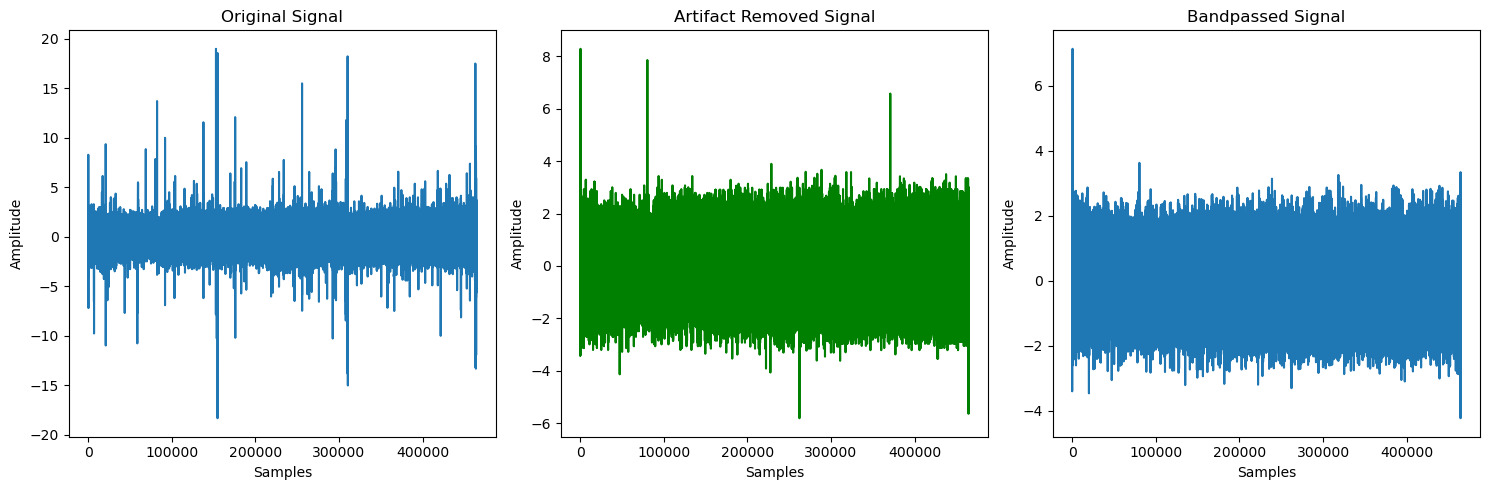

In [9]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Original signal
plt.subplot(1, 3, 1)
plt.plot(af8['AF8_normal'], label='Original')
plt.title('Original Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')


# Artifact removed signal
plt.subplot(1, 3, 2)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Original signal
plt.subplot(1, 3, 3)
plt.plot(af8['AF8_bandpassed'], label='Bandpassed')
plt.title('Bandpassed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Segmentation

In [10]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = af8[af8['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = af8[af8['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = af8[af8['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

In [12]:
segments_t1 = segment_column(eeg_data_t1['AF8_bandpassed'], gradcpt_data_t1)
segments_t2 = segment_column(eeg_data_t2['AF8_bandpassed'], gradcpt_data_t2)
segments_t3 = segment_column(eeg_data_t3['AF8_bandpassed'], gradcpt_data_t3)

### Discrete Wavelet Transform

In [13]:
segment_bands_t1 = [decompose_segment(segment) for segment in segments_t1]
segment_bands_t2 = [decompose_segment(segment) for segment in segments_t2]
segment_bands_t3 = [decompose_segment(segment) for segment in segments_t3]

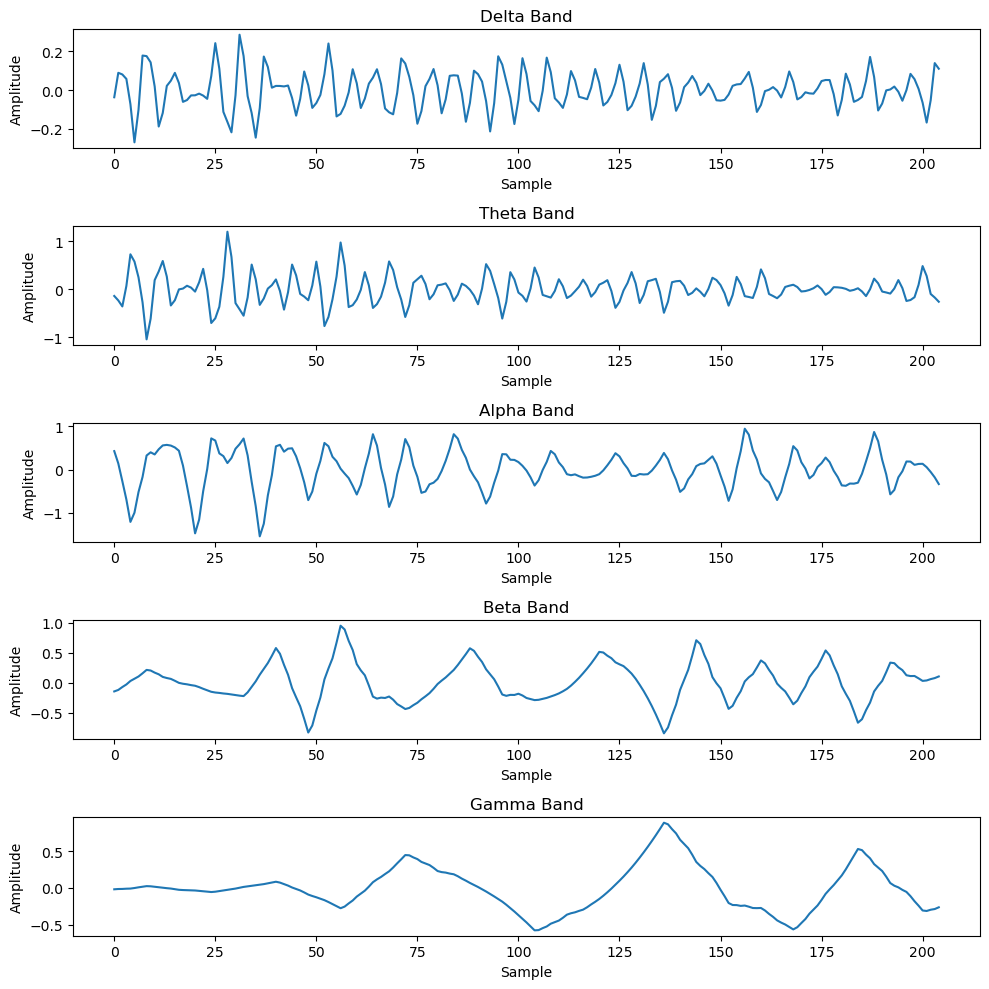

In [14]:
import matplotlib.pyplot as plt

first_segment_bands = segment_bands_t1[0]  # Get the bands for the first segment

num_bands = len(first_segment_bands)
fig, axes = plt.subplots(num_bands, 1, figsize=(10, 2 * num_bands))

# Plot each band in a separate subplot
for i, (band_name, band_signal) in enumerate(first_segment_bands.items()):
    ax = axes[i] if num_bands > 1 else axes  # Handle the case of a single subplot
    ax.plot(band_signal)
    ax.set_title(f"{band_name.capitalize()} Band")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


### Feature Computation

In [21]:
channel = 'AF8'
features_t1 = extract_features(channel, segment_bands_t1, gradcpt_data_t1)
features_t2 = extract_features(channel, segment_bands_t2, gradcpt_data_t2)
features_t3 = extract_features(channel, segment_bands_t3, gradcpt_data_t3)


TypeError: extract_features() takes 2 positional arguments but 3 were given

In [16]:
combined_features_df = pd.concat([features_t2, features_t3], ignore_index=True)

### Find 25 most and least important features

In [17]:
top_bot_25(combined_features_df)

Top 25 Most Important Features:
                         Feature     T-value  Abs T-value
6     theta_total_variation_win0  238.839787   238.839787
11    alpha_total_variation_win0  233.038148   233.038148
31   theta_total_variation_win-1  232.903943   232.903943
1     delta_total_variation_win0  228.598737   228.598737
56   theta_total_variation_win-2  227.166198   227.166198
36   alpha_total_variation_win-1  227.087548   227.087548
26   delta_total_variation_win-1  222.861122   222.861122
81   theta_total_variation_win-3  221.649264   221.649264
61   alpha_total_variation_win-2  221.576142   221.576142
51   delta_total_variation_win-2  217.600501   217.600501
86   alpha_total_variation_win-3  216.547767   216.547767
106  theta_total_variation_win-4  216.519746   216.519746
76   delta_total_variation_win-3  212.642124   212.642124
111  alpha_total_variation_win-4  211.764147   211.764147
131  theta_total_variation_win-5  211.747617   211.747617
101  delta_total_variation_win-4  207.95

## Training

In [18]:
for _ in range(7):
    from scipy.stats import ttest_ind
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.svm import SVC
    
    features = combined_features_df.iloc[:, :-1].values
    labels = combined_features_df.iloc[:, -1].values
    
    def select_top_features(X, y, num_features=15):
        # Perform a t-test across features
        t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
        # Select indices of top features based on smallest p-values
        top_features_indices = np.argsort(p_values)[:num_features]
        return top_features_indices
    
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
    
    balanced_acc_scores = []
    
    for train_index, test_index in outer_cv.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
    
        # Feature selection for the outer fold
        top_features_indices = select_top_features(X_train, y_train)
        X_train_selected = X_train[:, top_features_indices]
        X_test_selected = X_test[:, top_features_indices]
    
        # Inner CV for hyperparameter truning
        inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
        grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
        grid_search.fit(X_train_selected, y_train)
    
        best_model = grid_search.best_estimator_
        
    
        balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test_selected))
        balanced_acc_scores.append(balanced_acc)
    
    final_performance = np.mean(balanced_acc_scores)
    print(f'Final model balanced accuracy: {final_performance}')

Final model balanced accuracy: 0.6154957423176601
Final model balanced accuracy: 0.6261438973219796
Final model balanced accuracy: 0.6021886955448599
Final model balanced accuracy: 0.6059912378131557
Final model balanced accuracy: 0.6093325928668395
Final model balanced accuracy: 0.6074821670986055
Final model balanced accuracy: 0.6044842650870048


- delta from 1
- gamma from 40
- skip normalization ✅
- IIR filter instead of DWT ❌ resulted in accuract loss
### Multichannel
- normalize every channel separately